# Using SeisCL with python example
This small tutorial shows how to launch SeisCL from python to perform forward modeling. We will use [2004 BP velocity estimation benchmark model](http://wiki.seg.org/wiki/2004_BP_velocity_estimation_benchmark_model), which looks like this:

![BPmodel](http://s3.amazonaws.com/open.source.geoscience/open_data/bpvelanal2004/vel_6.25m.gif)


## Modules

First, we import modules we will need later

In [1]:
from  urllib.request import urlretrieve
import gzip
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate as intp
from mpl_toolkits.axes_grid1 import make_axes_locatable
import math
import subprocess
import sys
import time

%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(15, 7)

The two following modules are of particular interest in using SeisCL:

In [2]:
import segyio
import hdf5storage as h5mat
import h5py as h5

The first module is used to interact with segy files, and the second is used to read and write [hdf5](https://support.hdfgroup.org/HDF5/) files compatible with matlab format, version 7.3. Alternatively, you can use the package [h5py](http://www.h5py.org) which is more standard.

To install those packages, you can use pip in your terminal as follows:

In [3]:
%%bash
pip install hdf5storage
pip install segyio

## Download the model

We can download the data directly from the web. In the following, we download the compressed model files, uncompress them to the segy format. We only download files if model files are not present.

In [4]:
models_url={
        'vp':'http://s3.amazonaws.com/open.source.geoscience/open_data/bpvelanal2004/vel_z6.25m_x12.5m_exact.segy.gz',
        'rho':'http://s3.amazonaws.com/open.source.geoscience/open_data/bpvelanal2004/density_z6.25m_x12.5m.segy.gz', 
        'Salt':'http://s3.amazonaws.com/open.source.geoscience/open_data/bpvelanal2004/vel_z6.25m_x12.5m_saltindex.segy.gz',
        'water':'http://s3.amazonaws.com/open.source.geoscience/open_data/bpvelanal2004/vel_z6.25m_x12.5m_wbindex.segy.gz'}

models_gz={
        'vp':'vel_z6.25m_x12.5m_exact.segy.gz',
        'rho':'density_z6.25m_x12.5m.segy.gz', 
        'Salt':'vel_z6.25m_x12.5m_saltindex.segy.gz',
        'water':'vel_z6.25m_x12.5m_wbindex.segy.gz'}

models_segy={
        'vp':'vel_z6.25m_x12.5m_exact.segy',
        'rho':'density_z6.25m_x12.5m.segy', 
        'Salt':'vel_z6.25m_x12.5m_saltindex.segy',
        'water':'vel_z6.25m_x12.5m_wbindex.segy'}

for par in models_url:
    if not os.path.isfile(models_segy[par]):
        urlretrieve(models_url[par], models_gz[par])
        with gzip.open(models_gz[par], 'rb') as infile:
            with open(models_segy[par], 'wb') as outfile:
                for line in infile:
                    outfile.write(line)
        os.remove(models_gz[par])

We can now load the model into a numpy array. We only load the left part of the model here

In [5]:
models={
        'vp':None,
        'rho':None, 
        'Salt':None,
        'water':None}

for par in models: 
    with segyio.open(models_segy[par], "r" ) as segy:
        models[par]=np.transpose(np.array([segy.trace[trid] for trid in range(segy.tracecount) ]))
        models[par]=models[par][:,:1800]
        gz, gx = np.mgrid[:models[par].shape[0], :models[par].shape[1]]
        x=np.arange(0,models[par].shape[1],1)
        z=np.arange(0,models[par].shape[0],1)
        interpolator=intp.interp2d(x,z,models[par])
        xi=np.arange(0,models[par].shape[1],1)
        zi=np.arange(0,models[par].shape[0],2)
        models[par]=interpolator(xi,zi)

The BP model does not provide a shear wave velocity model, so we build one from the Vp model, using constant VP/VS ratio for sediments and salts

In [6]:
models['rho']*= 1000  
#Fundamentals of seismic rock physics by Wang 2001 
models['vs']= (models['vp'])/1.8 
#For salts, we take values from Elastic properties of rock salt: 
#Lab measurements and well log analysis in the Gulf of Mexico by Zong et al
#we take Vs/vp to be 2.92/4.75 (results at max pressure)
models['vs'][models['Salt']==0]=models['vp'][models['Salt']==0]/4.75*2.92;
models['vs'][models['water']==1]=0;

For demonstration purposes, it is easier to have a flat water bottom, we we modify the model a little bit here

In [7]:
b=np.argmax(models['water'][:,0]==0)
models['rho'][0:b,:]= models['rho'][0]  
models['vp'][0:b,:]= models['vp'][0] 
models['vs'][0:b,:]= models['vs'][0] 
models['water'][0:b,:]= models['water'][0] 

Let's look at what the model looks like:

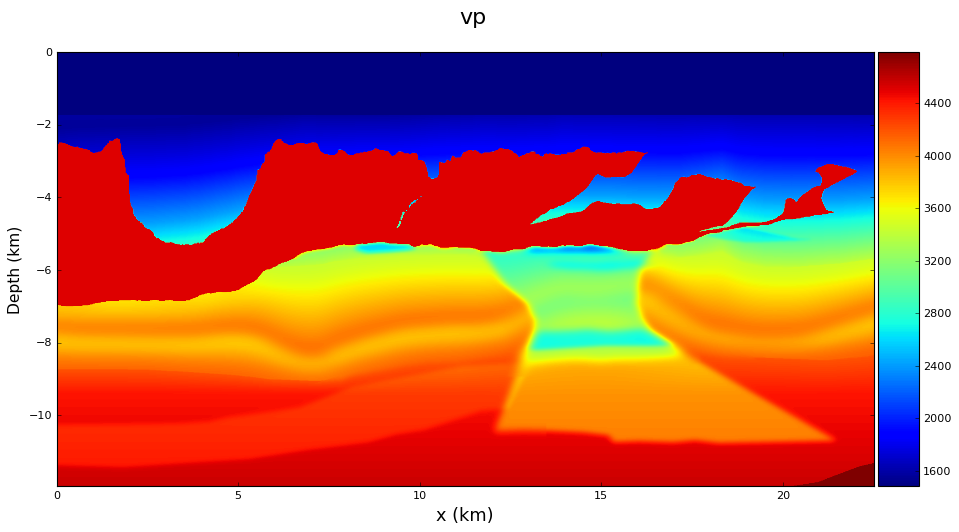

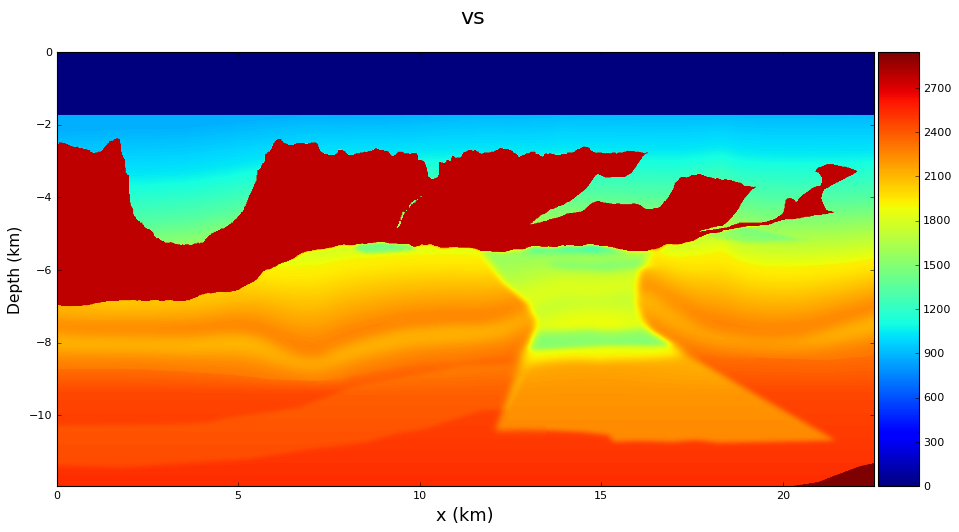

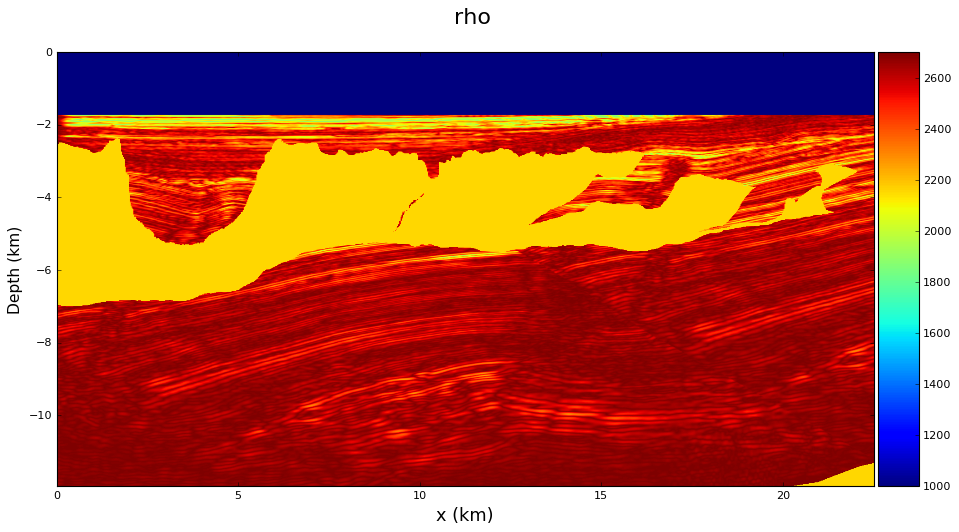

In [21]:
for par in ['vp','vs','rho']:  
    fig, ax = plt.subplots()
    fig.suptitle(par, fontsize=20)
    plt.xlabel('x (km)', fontsize=16)
    plt.ylabel('Depth (km)', fontsize=14)
    im = ax.imshow(models[par], 
                   interpolation='bilinear', 
                   extent=[0,models[par].shape[1]*0.0125,-models[par].shape[0]*0.0125,0])
    
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    
    plt.colorbar(im, cax=cax)
    
    plt.show()


## Building SeisCL input files
SeisCL requires several input files, with the extension .mat. All file are in the [hdf5](https://support.hdfgroup.org/HDF5/) format. Here's a list:

In [9]:
file="SeisCL"
filenames={}
filenames['model']=file+"_model.mat"    #File containing the model pareters
filenames['csts']=file+"_csts.mat"      #File containing the simulation constants
filenames['din']=file+"_din.mat"        #File containing the recorded data

Here's a list of output files :

In [10]:
filenames['dout']=file+"_dout.mat"      #File containing the seismograms output
filenames['gout']=file+"_gout.mat"      #File containing the gradient ouput
filenames['rms']=file+"_rms.mat"        #File containing the rms ouput
filenames['movout']=file+"_movie.mat"   #File containing the movie ouput


Files share all the same root name, in this case SeisCL, which can be arbitrary. The files suffixes are however required by SeisCL. For forward computations, only the _model and _csts files are required

### Constants file

Let's first build a dictionary containing all variables that can be found in the _csts file.

In [27]:
csts={}
csts['NX']=models['vp'].shape[1]              #Grid size in X
csts['NY']=1                #Grid size in Y (set to 1 for 2D)
csts['NZ']=models['vp'].shape[0]              #Grid size in Z
csts['ND']=2                #Flag for dimension. 3: 3D, 2: 2D P-SV,  21: 2D SH
csts['dh']=12.5             #Grid spatial spacing
csts['dt']=6*csts['dh']/(7*np.sqrt(2)*np.max(models['vp']))*0.95# Time step size
csts['NT']=int(15/csts['dt'] ) #Number of time steps
csts['freesurf']=1          #Include a free surface at z=0: 0: no, 1: yes
csts['FDORDER']=4           #Order of the finite difference stencil. Values: 2,4,6,8,10,12
csts['MAXRELERROR']=1       #Set to 1
csts['L']=0                 #Number of attenuation mechanism (L=0 elastic)
csts['f0']=1.5               #Central frequency for which the relaxation mechanism are corrected to the righ velocity
csts['FL']=np.array(5)     #Array of frequencies in Hz of the attenuation mechanism

csts['src_pos']=np.empty((5,0)) #Position of each shots. 5xnumber of sources. [sx sy sz srcid src_type]. srcid is the source number (two src with same srcid are fired simulatneously) src_type: 1: Explosive, 2: Force in X, 3: Force in Y, 4:Force in Z
csts['rec_pos']=np.empty((8,0)) #Position of the receivers. 8xnumber of traces. [gx gy gz srcid recid Not_used Not_used Not_used]. srcid is the source number recid is the trace number in the record
csts['src']=np.empty((csts['NT'],0))            #Source signals. NTxnumber of sources

csts['abs_type']=1          #Absorbing boundary type: 1: CPML, 2: Absorbing layer of Cerjan
csts['VPPML']=4000          #Vp velocity near CPML boundary
csts['NPOWER']=2            #Exponent used in CMPL frame update, the larger the more damping
csts['FPML']=5              #Dominant frequency of the wavefield
csts['K_MAX_CPML']=2        #Coeffienc involved in CPML (may influence simulation stability)
csts['nab']=16              #Width in grid points of the absorbing layer
csts['abpc']=6              #Exponential decay of the absorbing layer of Cerjan et. al.
csts['pref_device_type']=4  #Type of processor used: 2: CPU, 4: GPU, 8: Accelerator
csts['nmax_dev']=9999       #Maximum number of devices that can be used
csts['no_use_GPUs']=np.empty( (1,0) )  #Array of device numbers that should not be used for computation
csts['MPI_NPROC_SHOT']=1    #Maximum number of MPI process (nodes) per shot involved in domain decomposition

csts['back_prop_type']=2    #Type of gradient calculation: 1: backpropagation (elastic only) 2: Discrete Fourier transform
csts['par_type']=0        #Type of paretrization: 0:(rho,vp,vs,taup,taus), 1:(rho, M, mu, taup, taus), 2:(rho, Ip, Is, taup, taus)
csts['gradfreqs']=np.empty((1,0)) #Array of frequencies in Hz to calculate the gradient with DFT
csts['tmax']=csts['NT']*csts['dt']#Maximum time for which the gradient is to be computed
csts['tmin']=0              #Minimum time for which the gradient is to be computed
csts['scalerms']=0          #Scale each modeled and recorded traces according to its rms value, then scale residual by recorded trace rms
csts['scalermsnorm']=0      #Scale each modeled and recorded traces according to its rms value, normalized
csts['scaleshot']=0         #Scale all of the traces in each shot by the shot total rms value
csts['fmin']=0              #Maximum frequency for the gradient computation
csts['fmax']=45              #Minimum frequency for the gradient computation
csts['mute']=None           #Muting matrix 5xnumber of traces. [t1 t2 t3 t4 flag] t1 to t4 are mute time with cosine tapers, flag 0: keep data in window, 1: mute data in window
csts['weight']=None         # NTxnumber of geophones or 1x number of geophones. Weight each sample, or trace, according to the value of weight for gradient calculation.

csts['gradout']=0           #Output gradient 1:yes, 0: no
csts['gradsrcout']=0        #Output source gradient 1:yes, 0: no
csts['seisout']=3           #Output seismograms 1:velocities, 2: pressure, 3: velocities and pressure, 4: velocities and stresses
csts['resout']=0            #Output residuals 1:yes, 0: no
csts['rmsout']=0            #Output rms value 1:yes, 0: no
csts['movout']=0            #Output movie 1:yes, 0: no
csts['restype']=0           #Type of costfunction 0: raw seismic trace cost function. No other available at the moment

### Model File

The model file contains numpy arrays of the model parameters. The arrays must have 3 dimensions. For 2D modeling, set the Y dimension to a size of 1. If viscoelastic modeling is desired, two additional parameters are required, taup and taus. 

In [39]:
models['vp']=np.reshape(models['vp'], [csts['NZ'],csts['NY'],csts['NX']]) 
models['vs']=np.reshape(models['vs'], [csts['NZ'],csts['NY'],csts['NX']])
models['rho']=np.reshape(models['rho'], [csts['NZ'],csts['NY'],csts['NX']])

### Source and receivers position

We must also set the source and receivers position. First, we build a ricker wavelet to be our source:

In [13]:
tmin=-2/csts['f0']
t=np.zeros((csts['NT'],1))
t[:,0]=tmin+np.arange(0,csts['NT']*csts['dt'],csts['dt'] )
pf=math.pow(math.pi,2)*math.pow(csts['f0'],2)
ricker=np.multiply( (1.0-2.0*pf*np.power(t,2)), np.exp(-pf*np.power(t,2) )  )

Then, we assign the x and z coordinates of the receivers:

In [36]:
gx=np.zeros( len(range(csts['nab']+5,csts['NX']-2*csts['nab']-10,1)) )
gz=np.zeros( len(range(csts['nab']+5,csts['NX']-2*csts['nab']-10,1)) )
for jj in range(csts['nab']+5,csts['NX']-2*csts['nab']-10,1):
    gx[jj-csts['nab']-5]=(jj)*csts['dh']
    gz[jj-csts['nab']-5]=(np.argmax(models['water'][:,jj]==0)+1)*csts['dh']

Finally, we build the arrays src_pos, rec_pos and src that must be found in the _csts file. The src_pos array had dimesions 5 x number of sources, whereas rec_pos has 8 x number of receivers. 

In [15]:
for ii in range(csts['nab']+5,csts['NX']-2*csts['nab']-10,2000):
    toappend=np.zeros((5,1))
    toappend[0,:]=(ii)*csts['dh']  # x position
    toappend[1,:]=0                # y position
    toappend[2,:]=(6)*csts['dh']   # z position
    toappend[3,:]=ii               # Source id
    toappend[4,:]=1                # source type
    csts['src_pos']=np.append(csts['src_pos'], toappend, axis=1)
    csts['src']=np.append(csts['src'], ricker  , axis=1)
    
    toappend=np.stack([gx,      # x position
                       gx*0,    # y position
                       gz,      # z position
                       gz*0+ii, # source id  
                       np.arange(0,len(gx))+csts['rec_pos'].shape[1], # rec id (unique to each receiver)
                       gx*0,    # For future use
                       gx*0,    # For future use
                       gx*0],   # For future use
                       0)
    csts['rec_pos']=np.append(csts['rec_pos'], toappend, axis=1)

Finally, we have to write hdf5 to disc:

In [16]:
h5mat.savemat(filenames['csts'], 
              csts , 
              appendmat=False, format='7.3', 
              store_python_metadata=True, 
              truncate_existing=True)
h5mat.savemat(filenames['model'], 
              models , 
              appendmat=False, 
              format='7.3', 
              store_python_metadata=True, 
              truncate_existing=True)

## Running the simulations

We are now ready to lauch SeisCL. We will do so by using the subprocess module. The command to launch SeisCL takes the following form:

In [17]:
filepath=os.getcwd()
cmdlaunch='mpirun -np 1 ../../src/SeisCL_MPI '+filepath+'/'+file+' > '+filepath+'/out 2>'+filepath+'/err'
cmdlaunch

'mpirun -np 1 ../../src/SeisCL_MPI /Users/gabrielfabien-ouellet/Dropbox/Doctorat/Manuscrit/SeisCL/tests/BPmodel/SeisCL > /Users/gabrielfabien-ouellet/Dropbox/Doctorat/Manuscrit/SeisCL/tests/BPmodel/out 2>/Users/gabrielfabien-ouellet/Dropbox/Doctorat/Manuscrit/SeisCL/tests/BPmodel/err'

SeisCL is a MPI program, so it must be run through mpirun for more than one process. By default, it will use every computing device found on the machines (every GPUs for example). The first argument is the root names of the files. A second argument can be givent to point to a datafile to be read for gradient computation. 

Finally, we can launch the program and wait for its execution

In [19]:
pipes = subprocess.Popen(cmdlaunch,stdout=subprocess.PIPE, stderr=subprocess.PIPE,shell=True)
while (pipes.poll() is None):
    time.sleep(1)
sys.stdout.write('Forward calculation completed \n')
sys.stdout.flush()

Forward calculation completed 


## Plotting the data

We can now load the data in python:

In [24]:
dout = h5.File('SeisCL_dout.mat','r')

vx_el=dout['vxout']
vx_el=np.transpose(vx_el[:,::20]) 
p_el=dout['pout']
p_el=np.transpose(p_el[:,::20])

The modeled data looks like this:

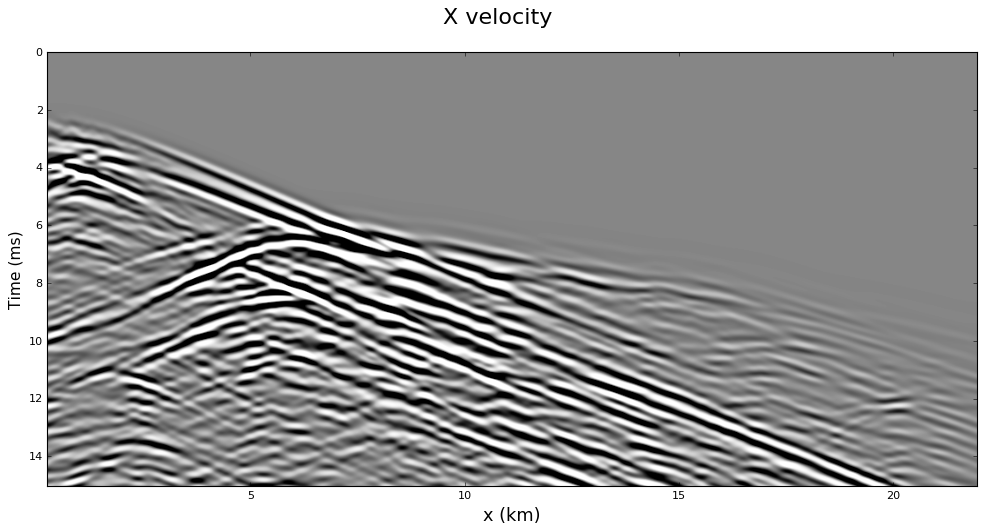

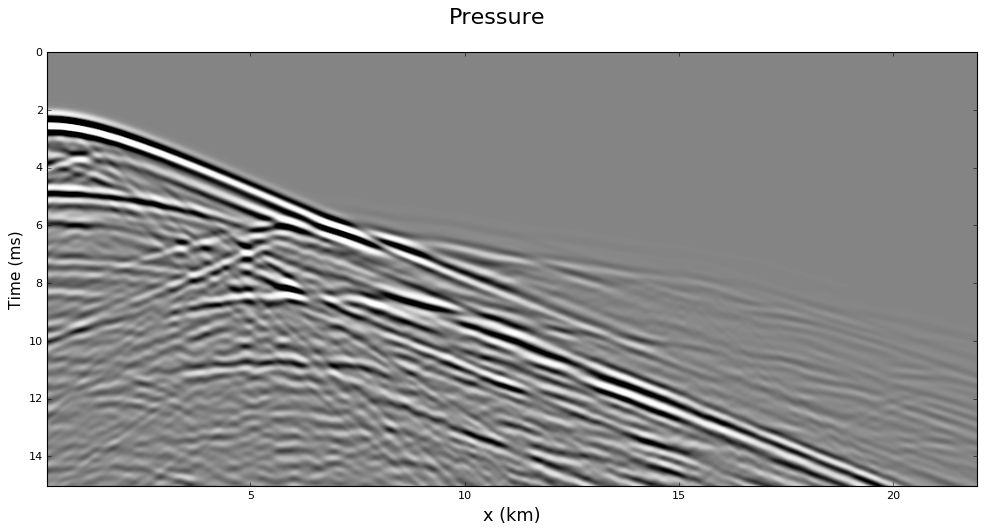

In [38]:
clip=0.2;
vmin=np.min(vx_el)*clip;
vmax=np.max(vx_el)*clip;
fig, ax = plt.subplots()
im = ax.imshow(vx_el, 
               interpolation='bilinear', 
               vmin=vmin, 
               vmax=vmax, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper',
               extent=[gx[0]/1000,gx[-1]/1000, vx_el.shape[0]*csts['dt']*20,0]
               )
fig.suptitle('X velocity', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.show()

vmin=np.min(p_el)*clip;
vmax=np.max(p_el)*clip;
fig, ax = plt.subplots()
im = ax.imshow(p_el, 
               interpolation='bilinear', 
               vmin=vmin, 
               vmax=vmax, 
               cmap=plt.get_cmap('Greys'), 
               aspect='auto',
               origin='upper',
               extent=[gx[0]/1000,gx[-1]/1000, p_el.shape[0]*csts['dt']*20,0]
               )
fig.suptitle('Pressure', fontsize=20)
plt.xlabel('x (km)', fontsize=16)
plt.ylabel('Time (ms)', fontsize=14)
plt.show()

In [ ]:
<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#999; background:#fff;">
Created with Jupyter, delivered by Fastly, rendered by Rackspace.
</footer>